<a href="https://colab.research.google.com/github/faizaslam11/ECG_model_arrhythmia/blob/main/Ecg_model_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the cleaned data
cleaned_data_path = '/content/all-samples-training-cleaned.csv'
df_cleaned = pd.read_csv(cleaned_data_path)

# Extract features and labels
features = df_cleaned.drop('Arrhythmia', axis=1)
labels = df_cleaned['Arrhythmia']

# Split into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create DataFrames for training and testing data
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save training and testing datasets to separate CSV files
train_data_path = '/content/ecg-training-data.csv'
test_data_path = '/content/ecg-testing-data.csv'

train_data.to_csv(train_data_path, index=False)
test_data.to_csv(test_data_path, index=False)

train_data_path, test_data_path

('/content/ecg-training-data.csv', '/content/ecg-testing-data.csv')

Epoch 1/20
74/74 [==============================] - 6s 23ms/step - loss: 0.5137 - accuracy: 0.9531 - val_loss: 0.0914 - val_accuracy: 0.9744
Epoch 2/20
74/74 [==============================] - 1s 10ms/step - loss: 0.0873 - accuracy: 0.9684 - val_loss: 0.0680 - val_accuracy: 0.9813
Epoch 3/20
74/74 [==============================] - 1s 10ms/step - loss: 0.0683 - accuracy: 0.9731 - val_loss: 0.0626 - val_accuracy: 0.9796
Epoch 4/20
74/74 [==============================] - 1s 10ms/step - loss: 0.0598 - accuracy: 0.9718 - val_loss: 0.0536 - val_accuracy: 0.9813
Epoch 5/20
74/74 [==============================] - 1s 10ms/step - loss: 0.0506 - accuracy: 0.9761 - val_loss: 0.0510 - val_accuracy: 0.9847
Epoch 6/20
74/74 [==============================] - 1s 10ms/step - loss: 0.0452 - accuracy: 0.9834 - val_loss: 0.0499 - val_accuracy: 0.9864
Epoch 7/20
74/74 [==============================] - 1s 10ms/step - loss: 0.0411 - accuracy: 0.9817 - val_loss: 0.0518 - val_accuracy: 0.9864
Epoch 8/20
74

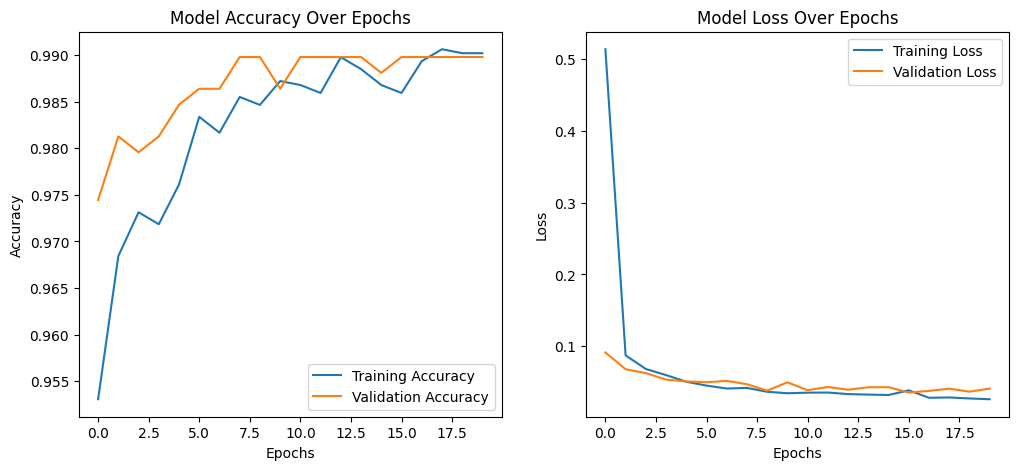

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import layers, models

# Load your pre-split training and testing datasets
train_data_path = '/content/ecg-training-data.csv'
test_data_path = '/content/ecg-testing-data.csv'

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

# Extract features and labels for training and testing
X_train = train_df.drop('Arrhythmia', axis=1)
y_train = train_df['Arrhythmia']

X_test = test_df.drop('Arrhythmia', axis=1)
y_test = test_df['Arrhythmia']

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for RNN input (samples, timesteps, features)
X_train_rnn = np.expand_dims(X_train_scaled, axis=2)
X_test_rnn = np.expand_dims(X_test_scaled, axis=2)

# Build the RNN model
rnn_model = models.Sequential([
    layers.LSTM(64, input_shape=(X_train_rnn.shape[1], 1), return_sequences=True),
    layers.LSTM(32),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(np.unique(y_train_encoded)), activation='softmax')  # Output layer for classification
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and capture history
rnn_history = rnn_model.fit(X_train_rnn, y_train_encoded, epochs=20, batch_size=32, validation_data=(X_test_rnn, y_test_encoded))

# Plot training vs. validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')

plt.show()

In [5]:
# Evaluate the model and print accuracy in percentages
test_loss, test_accuracy = rnn_model.evaluate(X_test_rnn, y_test_encoded)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

19/19 [==============================] - 0s 6ms/step - loss: 0.0411 - accuracy: 0.9898
Test Accuracy: 98.98%


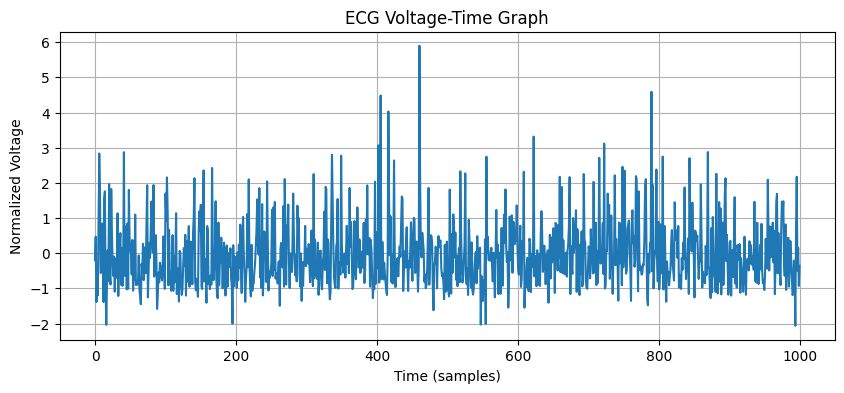

In [6]:
# Voltage-Time Graph (Example from your training data)
plt.figure(figsize=(10, 4))
# Assuming the first feature (e.g., 'Amplitude') represents voltage-time data
ecg_voltage_time = X_train_scaled[:, 0]  # Adjust the index as needed to plot the relevant feature
plt.plot(ecg_voltage_time[:1000])  # Plot a limited portion of the signal
plt.xlabel('Time (samples)')
plt.ylabel('Normalized Voltage')
plt.title('ECG Voltage-Time Graph')
plt.grid(True)
plt.show()

19/19 [==============================] - 2s 6ms/step


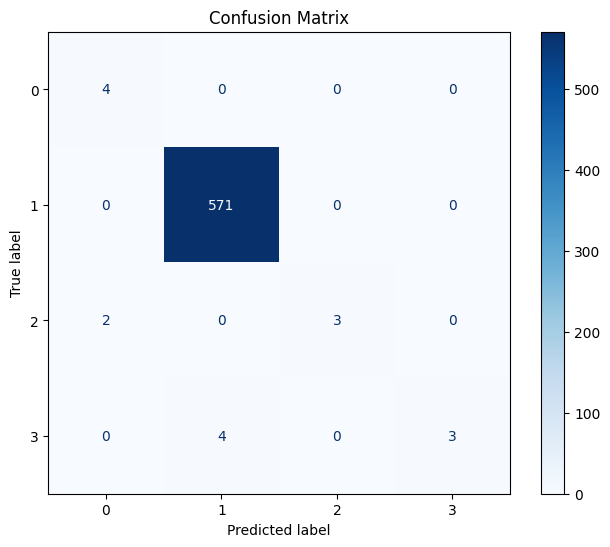

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred_probs = rnn_model.predict(X_test_rnn)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
display_labels = label_encoder.classes_

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels).plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()